In [26]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

# Collect Dataset
Collect the dataset of popular native New Zealand birds:

1. Kiwi
2. Fantail
3. Kea
4. Kakapo

In [27]:
key = os.environ.get('AZURE_SEARCH_KEY', '6a0cd115bcb54b0cab84b8315a6e95c8')
bird_types = 'kiwi','fantail','kea','kakapo'
path = Path('birds')

In [28]:
if not path.exists():
    path.mkdir()
    for i in bird_types:
        dest = (path/i)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{i} bird')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [49]:
#Note: Run from here after cleaning the dataset
fns = get_image_files(path)
fns

(#554) [Path('birds/kiwi/00000000.jpg'),Path('birds/kiwi/00000006.jpg'),Path('birds/kiwi/00000002.jpg'),Path('birds/kiwi/00000003.jpg'),Path('birds/kiwi/00000004.jpg'),Path('birds/kiwi/00000010.jpg'),Path('birds/kiwi/00000012.jpg'),Path('birds/kiwi/00000007.jpg'),Path('birds/kiwi/00000013.png'),Path('birds/kiwi/00000001.jpg')...]

In [50]:
#Check for corrupt images
failed = verify_images(fns)
failed.map(Path.unlink);

# Turn data in DataLoaders object

In [51]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))

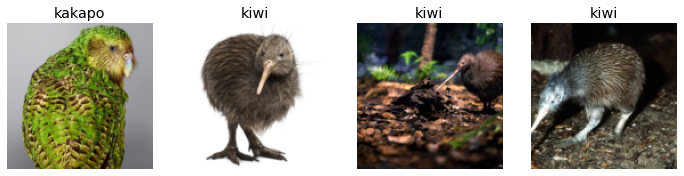

In [52]:
dls = birds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

# Train Transfer Learning Model

In [53]:
birds = birds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = birds.dataloaders(path)

In [54]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.391444,0.193431,0.045455,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.222029,0.071920,0.036364,00:08
1,0.167838,0.034457,0.009091,00:08
2,0.125996,0.013816,0.009091,00:09
3,0.094791,0.011719,0.000000,00:09


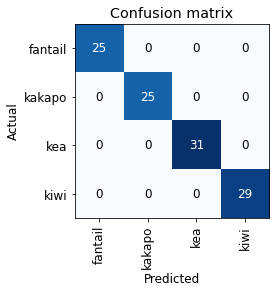

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

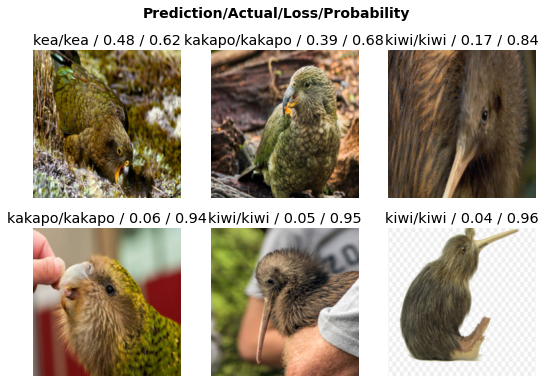

In [56]:
interp.plot_top_losses(6,nrows=2)

# Clean data using ImageClassifierCleaner

In [57]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [58]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# Turn model into an online application

In [67]:
learn.export()
learn_inf = load_learner(path/'export.pkl')

In [68]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [69]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [70]:
img = PILImage.create(btn_upload.data[-1])

In [71]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [72]:
pred,pred_idx,probs = learn_inf.predict(img)

In [73]:
lbl_pred = widgets.Label()
lbl_pred.value = f'prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='prediction: fantail; Probability: 1.0000')

In [74]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [75]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [76]:
# Final Result
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your bird!'),
     btn_upload, btn_run, out_pl, lbl_pred])

# Convert notebook into a Web-App

In [77]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.7 OK
